# AK8 Tagger

In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from time import time

In [2]:
new_dir = os.path.join("C:/", "Shared", "Tesi magistrale", "databases")
stable_dir = os.path.join("C:/", "Shared", "Tesi magistrale", "databases", "stable")
dir_path = stable_dir
if(os.path.exists(dir_path) and os.path.isdir(dir_path)):
    print("Found!")
    files_names = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]
    for f in files_names:
        print('\t%s' % f)
else:
    print("!!! NOT FOUND !!!")

Found!
	VZZ_1618.csv
	VZZ_1618_TagAK4.csv
	VZZ_1618_TagAK8.csv
	ZZTo4l_2016.csv
	ZZTo4l_2016_TagAK4.csv
	ZZTo4l_2016_TagAK8.csv
	ZZTo4l_2017.csv
	ZZTo4l_2017_TagAK8.csv


In [3]:
'''
def count_lines(f):
    lines = 0
    buf_size = 1024 * 1024
    read_f = f.read # loop optimization
    buf = read_f(buf_size)
    while buf:
        lines += buf.count('\n')
        buf = read_f(buf_size)
    f.seek(0)
    return lines
'''
def get_raw_data(file_path, nlines=None):
    try:
        in_file = open(file_path, 'r')  #TODO: Add an header row in the csv builder (DBGenerator.cc)
        raw_data = pd.read_csv(in_file, delimiter=',', header=None, nrows=nlines) #raw_data is a pandas.DataFrame
    except IOError as e:
        print(e)
        return None
    else:
        in_file.close()
        return raw_data

In [4]:
def drawPoints(source, **kwargs):
    errTrain = [source[a]['train'] for a in source.keys()]
    errTest = [source[a]['test'] for a in source.keys()]
    print(source.keys())
    plt.title(kwargs.get("title", "Default Tittle"))
    plt.scatter(source.keys(), errTest, label='test')
    plt.scatter(source.keys(), errTrain, label='train')
    if(kwargs.get("logx", True)):
        plt.xlabel('log10(%s)' % kwargs.get("xlabel", "x axis"))
        plt.gca().set_xscale('log')
    else:
        plt.xlabel(kwargs.get("xlabel", "x axis"))
    plt.ylabel(kwargs.get("ylabel", "Error"))
    plt.legend()
    pass

In [5]:
def grid_plot(data, nx, ny, **kwargs): #n_ = range of _
    scores = data.reshape(ny.shape[0], nx.shape[0])
    title = kwargs.get("title", "Title")
    
    if(kwargs.get("log", True)):
        scores = np.vectorize(lambda x: -math.log10(1-x))(scores)
        title += " (-log(1-x))"
        #title.join(" (-log(1-x))")

    plt.figure(figsize=(8, 8))

    plt.imshow(scores, interpolation='nearest', origin='lower')#, cmap=plt.cm.hot)
    plt.title(title)
    if(kwargs.get("logx", True)):
        plt.xlabel('log10(%s)' % kwargs.get("lx", "lx"))
        plt.xticks(np.arange(len(nx)), map(lambda x : round(math.log10(x),2), nx))
    else:
        plt.xlabel(kwargs.get("lx", "lx"))
        plt.xticks(np.arange(len(nx)), map(lambda x : round(x,3), nx))
    
    if(kwargs.get("logy", True)):
        plt.ylabel('log10(%s)' % kwargs.get("ly", "ly"))
        plt.yticks(np.arange(len(ny)), map(lambda x : round(math.log10(x),2), ny))
    else:
        plt.ylabel(kwargs.get("ly", "ly"))
        plt.yticks(np.arange(len(ny)), map(lambda x : round(x,3), ny))
    plt.colorbar()

In [6]:
def overf_log(grid):
    if(grid.cv_results_.get('mean_train_score') is None):
        print("Error: mean_train_score not found")
        return
    if(grid.cv_results_.get('mean_test_score') is None):
        print("Error: mean_test_score not found")
        return
    overfit = (grid.cv_results_['mean_train_score'] - grid.cv_results_['mean_test_score'])
    index = np.argmax(grid.cv_results_['mean_test_score'])
    print("Score at best params: %.2f" % (grid.cv_results_['mean_test_score'][index]))
    print("Overfit at best params = %.2g" % (overfit[index]))

# Start

In [7]:
from sklearn.model_selection import train_test_split

data_path = os.path.join(dir_path, "VZZ_1618_TagAK8.csv")
AK8data_raw = get_raw_data(data_path)
feat8_raw   = AK8data_raw.drop(0, axis=1).drop(1, axis=1)
target8_VZZ = AK8data_raw[0]
weight8_VZZ = AK8data_raw[1]

AK8data = AK8data_raw[(AK8data_raw[1]>0)]
features8 = AK8data.drop(0, axis=1).drop(1, axis=1)
target8   = AK8data[0]
weight8   = AK8data[1]

print("n_samples:", AK8data.shape[0], "  Features:", features8.shape[1])
print("--------------------------------------")
nz = np.count_nonzero(AK8data[0].to_numpy())
z = len(target8) - nz
print('"1" =', nz, '\n"0" =', z)

n_samples: 1046   Features: 15
--------------------------------------
"1" = 877 
"0" = 169


In [8]:
from sklearn.utils import shuffle

#2016 (broken) data
#AK8data_raw_plus = get_raw_data(os.path.join(dir_path, "ZZTo4l_2016_TagAK8.csv"), nz - z)
#2017 (working, I hope) data
AK8data_raw_plus = get_raw_data(os.path.join(dir_path, "ZZTo4l_2017_TagAK8.csv"), nz - z)

AK8data_plus = AK8data_raw_plus[(AK8data_raw_plus[1]>0)]

print("new samples: ", AK8data_plus.shape[0])

assert (AK8data.shape[1] == AK8data_plus.shape[1]), "ERROR: Datasets have different shapes!"
AK8total = pd.concat([AK8data, AK8data_plus], ignore_index=True)
shuffle(AK8total).reset_index(inplace=True, drop=True)

features8 = AK8total.drop(0, axis=1).drop(1, axis=1)
target8   = AK8total[0]
weight8   = AK8total[1]
print("n_samples:", AK8total.shape[0], "  Features:", features8.shape[1])

X8_train, X8_valid, y8_train, y8_valid = train_test_split(features8, target8.to_numpy(), test_size=0.2, random_state=42)
print("Train size:", y8_train.shape[0], "  Validation size:", y8_valid.shape[0])

print("--------------------------------------")
nz_tot = np.count_nonzero(target8.to_numpy())
z_tot = len(target8) - nz_tot
print('"1" =', nz_tot, '\n"0" =', z_tot)

new samples:  699
n_samples: 1745   Features: 15
Train size: 1396   Validation size: 349
--------------------------------------
"1" = 877 
"0" = 868


In [77]:
from sklearn.ensemble import AdaBoostClassifier

ErrAda8 = {}
AdaBoost8 = AdaBoostClassifier(random_state=42)

start = time()
for ntrees in np.logspace(1.5, 3.5, 10).astype(int):#[1, 3, 5, 10, 15, 20, 25]:
    AdaBoost8.set_params(**{"n_estimators": ntrees, "learning_rate": 0.04})
    AdaBoost8.fit(X8_train, y8_train)
    
    train_score = AdaBoost8.score(X8_train, y8_train)
    test_score  = AdaBoost8.score(X8_valid, y8_valid)
    #print("Score in = %.3f - Score out = %.3f - Elapsed Time = %.2f s" % (train_score, test_score, time()-start))

    ErrAda8[ntrees] = {'train': 1-train_score, 'test': 1-test_score}
print("Elapsed Time = %.2f s" % (time()-start))

Elapsed Time = 33.73 s


dict_keys([31, 52, 87, 146, 244, 408, 681, 1136, 1895, 3162])


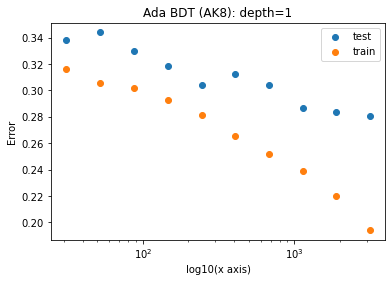

In [78]:
drawPoints(ErrAda8, title="Ada BDT (AK8): depth=1", xaxis="Trees' depth", logx=True)

In [82]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

AdaBoost8 = AdaBoostClassifier(random_state=42)
nTrees_Ada8 = np.logspace(2.5, 4., 6).astype(int) #(1, 2.4, 8)
lRate_Ada8  = np.logspace(-1.8, -1., 6)         #(-1., -0.3, 8)

with np.printoptions(formatter={'float': lambda x: '%.3g' %(x)}):
    print("nTrees =", nTrees_Ada8, "\t\t(", np.vectorize(lambda x: math.log10(x))(nTrees_Ada8), ")")
    print("lRate =" , lRate_Ada8 , "\t(", np.vectorize(lambda x: math.log10(x))(lRate_Ada8) , ")")

grid_Ada8 = GridSearchCV(AdaBoost8, param_grid={'n_estimators': nTrees_Ada8, 'learning_rate': lRate_Ada8}, 
                            verbose=10, scoring='roc_auc', cv=5, n_jobs=-1, return_train_score=True)

start = time()
grid_Ada8.fit(features8, target8)
sec = time() - start
print("Elapsed time: %.0f s (%d\'%.d\")" % (sec, (int)(sec/60), int(sec)%60))
nTrees_best_Ada8 = grid_Ada8.best_params_['n_estimators']
lRate_best_Ada8  = grid_Ada8.best_params_['learning_rate']
print ("best parameter choice: nTrees = %.2f (10^%.2f)" % (nTrees_best_Ada8, math.log10(nTrees_best_Ada8)))
print ("best parameter choice: lRate  = %.2f (10^%.2f)" % (lRate_best_Ada8, math.log10(lRate_best_Ada8)))

nTrees = [  316   630  1258  2511  5011 10000] 		( [2.5 2.8 3.1 3.4 3.7 4] )
lRate = [0.0158 0.0229 0.0331 0.0479 0.0692 0.1] 	( [-1.8 -1.64 -1.48 -1.32 -1.16 -1] )
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 16

Elapsed time: 1093 s (18'13")
best parameter choice: nTrees = 2511.00 (10^3.40)
best parameter choice: lRate  = 0.07 (10^-1.16)


In [19]:
grid_plot(grid_Ada8.cv_results_['mean_test_score'], nTrees_Ada8, lRate_Ada8, 
          lx="n trees", ly="learning rate", title="",#"AdaBoost8 - Score", 
          log=False, logx=False, logy=False)
print("Best score = %.4f %%" % (grid_Ada8.best_score_*100))
if(nTrees_best_Ada8==nTrees_Ada8[0]):
    print("Limit on nTrees: optimal may be lower")
elif(nTrees_best_Ada8==nTrees_Ada8[-1]):
    print("Limit on nTrees: optimal may be higher")
if(lRate_best_Ada8==lRate_Ada8[0]):
    print("Limit on lRate:  optimal may be lower")
elif(lRate_best_Ada8==lRate_Ada8[-1]):
    print("Limit on lRate:  optimal may be higher")

NameError: name 'grid_Ada8' is not defined

Score at best params: 0.77
Overfit at best params = 0.15


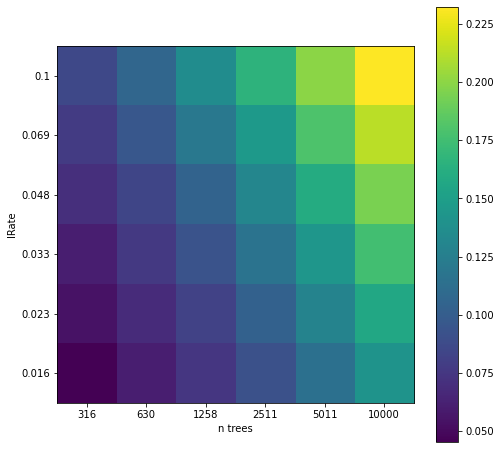

In [98]:
overfit8 = (grid_Ada8.cv_results_['mean_train_score']-grid_Ada8.cv_results_['mean_test_score'])
overf_log(grid_Ada8)
grid_plot(overfit8, nTrees_Ada8, lRate_Ada8, title="",#"AdaBoost8 - Overfit", 
          lx="n trees", ly="lRate", logx=False, logy=False, log=False)

In [9]:
from sklearn.ensemble import AdaBoostClassifier
#Ada8 = AdaBoostClassifier(n_estimators=nTrees_best_Ada8, learning_rate=lRate_best_Ada8, random_state=42)
Ada8 = AdaBoostClassifier(n_estimators=2511, learning_rate=0.0692, random_state=42)
start = time()
Ada8.fit(X8_train, y8_train)
print("Elapsed time: %.3g s" % (time() - start))

Elapsed time: 10.8 s


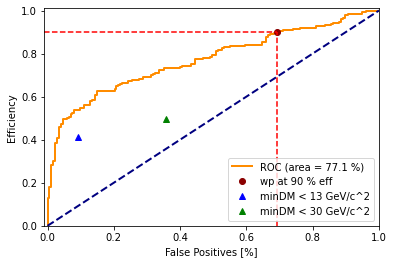

In [11]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y8_valid, Ada8.predict_proba(X8_valid)[:, 1])
auc_test = auc(fpr, tpr)

eff = 0.90
wp_fpr = fpr[np.searchsorted(tpr, eff, side='right')]

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC (area = %.1f %%)' % (100*auc_test), linestyle='-')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot((wp_fpr), (eff), 'o', color='darkred', label='wp at %.0f %% eff' % (eff*100))
#plt.plot((0.214019, 0.356657),(0.478722, 0.624044), "go", label="cut on minDM")
plt.plot((0.09163),(0.41418) , "b^", label="minDM < 13 GeV/c^2")
plt.plot((0.356657),(0.49758), "g^", label="minDM < 30 GeV/c^2")
#plt.plot((0.15225), (0.52233), "b^", label="minDM < 40 GeV/c^2")
plt.plot((-0.01, wp_fpr),(eff, eff), "r--")
plt.plot((wp_fpr, wp_fpr),(0, eff), "r--")

#plt.plot(baks,sigs)

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positives [%]')
plt.ylabel('Efficiency')
#plt.title('ROC AK8 in VZZ (Validation)')
plt.legend(loc="lower right")

In [91]:
i_classic = np.searchsorted(fpr, 0.109, side='right')
print("< 13 GeV/c^2 ", (0.109*100, 0.41418*100, tpr[i_classic]*100))
i_classic = np.searchsorted(fpr, 0.356657, side='right')
print("< 30 GeV/c^2 ", (0.356657*100, 0.49758*100, tpr[i_classic]*100))

< 13 GeV/c^2  (10.9, 41.418, 54.54545454545454)
< 30 GeV/c^2  (35.6657, 49.758, 73.29545454545455)


In [16]:
# Working point at 95% efficiency
i_wp = np.searchsorted(tpr, 0.95, side='right')
print("----- Working point at efficiency = 95 % -----")
print("Index: %i/%i" % (i_wp, len(thresholds)))
print('False positives: %.2f%% - threshold: %.3g' % (fpr[i_wp]*100, thresholds[i_wp]))
print("----- ----- ----- ----- ----- ----- ----- -----\n")

i_wp = np.searchsorted(tpr, 0.90, side='right')
print("----- Working point at efficiency = 90 % -----")
print("Index: %i/%i" % (i_wp, len(thresholds)))
print('False positives: %.2f %% - threshold: %.3g' % (fpr[i_wp]*100, thresholds[i_wp]))
print("----- ----- ----- ----- ----- ----- ----- -----")

----- Working point at efficiency = 95 % -----
Index: 124/136
False positives: 88.44% - threshold: 0.496
----- ----- ----- ----- ----- ----- ----- -----

----- Working point at efficiency = 90 % -----
Index: 106/136
False positives: 69.36 % - threshold: 0.498
----- ----- ----- ----- ----- ----- ----- -----


Most important: 11


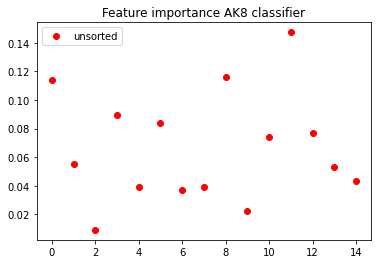

In [13]:
print("Most important:", np.argmax(Ada8.feature_importances_))
#plt.plot(np.sort(Ada8.feature_importances_)[::-1], "ro", label='sorted')
plt.plot(Ada8.feature_importances_, "ro", label='unsorted')
plt.title("Feature importance AK8 classifier")
plt.legend()
pass

In [104]:
from pickle import Pickler

start=time()
Ada8.fit(features8, target8)
filepath = os.path.join("C:/", "Shared", "VZZ_AK8_tree.pkl")
print("Training time = %.3g s" % (time() - start))
with open(filepath, mode='w+b') as file: # "C:/Shared/VZZ_AK4_tree.pkl"
    pickler = Pickler(file)#, protocol=3)
    pickler.dump(Ada8)
    del pickler

size=os.stat(filepath).st_size
j = math.floor(math.log(size,2)/10)
print("File size: %.3g %sB  (at %s)" % (size/1024**j, ['','K','M','G'][j], filepath))
del size, j

Training time = 11.3 s
File size: 1.6 MB  (at C:/Shared\VZZ_AK8_tree.pkl)


In [105]:
from pickle import Unpickler

obj_path = os.path.join("C:/", "Shared", "VZZ_AK8_tree.pkl")
with open(obj_path, mode='rb') as file:
    unpickler = Unpickler(file)
    loaded_Ada8 = unpickler.load()
    del unpickler

In [9]:
from sklearn.ensemble import AdaBoostClassifier
#Ada8 = AdaBoostClassifier(n_estimators=nTrees_best_Ada8, learning_rate=lRate_best_Ada8, random_state=42)
Ada8 = AdaBoostClassifier(n_estimators=2511, learning_rate=0.0692, random_state=42)
Ada8.fit(features8, target8)

AdaBoostClassifier(learning_rate=0.0692, n_estimators=2511, random_state=42)

In [10]:
#loaded_pred = loaded_Ada8.predict_proba(features8)[:,1]
live_pred = Ada8.predict_proba(features8)[:,1]

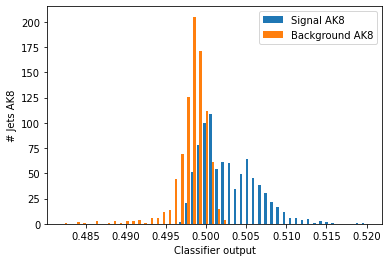

In [11]:
plt.hist([loaded_pred[target8==1], loaded_pred[target8==0]], label=['Signal AK8', 'Background AK8'], bins=50)
plt.xlabel("Classifier output")
plt.ylabel("# Jets AK8")
plt.legend()
pass

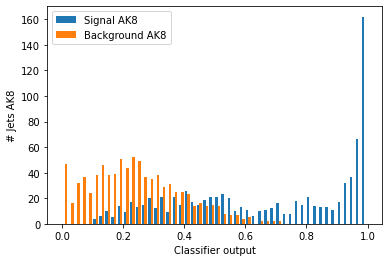

In [12]:
from scipy.special import erf
my_erf = lambda x,mean=loaded_pred.mean(),std=loaded_pred.std(): (erf((x-mean)/std) + 1)/2
spread_pred = np.vectorize(my_erf)(loaded_pred)

plt.hist([spread_pred[target8==1], spread_pred[target8==0]], 
         label=['Signal AK8', 'Background AK8'], bins=50)
plt.xlabel("Classifier output")
plt.ylabel("# Jets AK8")
plt.legend()
pass

### SVC (RBF kernel)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

rbf = SVC(kernel='rbf', probability=False, cache_size=1000)
Crange_rbf = np.logspace(-0.5, 0.5, 16)

start = time()
# Old scoring = 'average_precision'
grid_rbf = GridSearchCV(rbf, param_grid={'C': Crange_rbf}, scoring='roc_auc', cv=5, n_jobs=-1, return_train_score=True)
grid_rbf.fit(features8, target8)  # Cross-validate with all data
print("Elapsed time: %.0f s" % (time() - start))
C_best_rbf = grid_rbf.best_params_['C']
print ("best parameter choice: C = %.2f (10^%.1f)" % (C_best_rbf, math.log10(C_best_rbf)))

#result: C_best_rbf = 10^-0.9 = 0.14

In [ ]:
plt.title("RBF SVC - Best C = %.2e" % (grid_rbf.best_params_['C']))
plt.semilogx(Crange_rbf, grid_rbf.cv_results_['mean_test_score']);
plt.grid()
print("Best score = %.2f" % (grid_rbf.best_score_))

In [ ]:
plt.title("RBF SVC - Overfit")
overfit = grid_rbf.cv_results_['mean_train_score']-grid_rbf.cv_results_['mean_test_score']
plt.semilogx(Crange_rbf, overfit);
plt.grid()
print("Mean overfit = %.2f" % (overfit.mean()))

In [ ]:
rbf2 = SVC(kernel='rbf', probability=False, cache_size=1000)
Crange_rbf2 = np.logspace(-0.5, 1.0, 10)
Gammas_rbf2 = np.logspace(-2.5, -1.5, 10)

start = time()
grid_rbf2 = GridSearchCV(rbf2, param_grid={'C': Crange_rbf2, 'gamma': Gammas_rbf2}, 
                            scoring='roc_auc', cv=5, n_jobs=-1, return_train_score=True)
grid_rbf2.fit(features8, target8)
print("Elapsed time: %.0f s" % (time() - start))
C_best_rbf2 = grid_rbf2.best_params_['C']
gamma_best_rbf2 = grid_rbf2.best_params_['gamma']
print ("best parameter choice: C = %.2f (10^%.2f)" % (C_best_rbf2, math.log10(C_best_rbf2)))
print ("best parameter choice: gamma = %.2f (10^%.2f)" % (gamma_best_rbf2, math.log10(gamma_best_rbf2)))

In [ ]:
grid_plot(grid_rbf2.cv_results_['mean_test_score'], Gammas_rbf2, Crange_rbf2, 
          lx="Gamma", ly="C", title="RBF SVC - Score")
print("Best score = %.2f" % (grid_rbf2.best_score_))

In [ ]:
overfit = (grid_rbf2.cv_results_['mean_train_score']-grid_rbf2.cv_results_['mean_test_score']).reshape(Crange_rbf2.shape[0], Gammas_rbf2.shape[0])
print("Mean overfit = %.2f" % (overfit.mean()))
grid_plot(overfit, Crange_rbf2, Gammas_rbf2, title="RBF SVC - Overfit", lx="Gamma", ly="C")

In [ ]:
# Convert to script
# !jupyter nbconvert --to script config_template.ipynb

# Stuff

[0.0786439  0.38383943 0.41417711 0.42220132 0.44516248 0.47754832
 0.49758002 0.52232789 0.60938775 0.70319335 0.88642653 0.99349678]
[0.02211025 0.06915874 0.09162929 0.10077752 0.10903761 0.11251586
 0.1201982  0.15224805 0.25632862 0.56212328 0.84975299 1.00000078]
(10.9), (44.5)


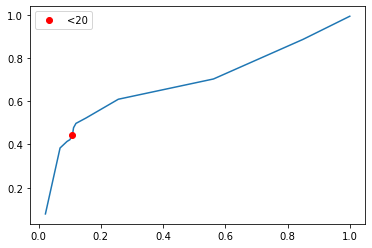

In [90]:
'''
features8
target8
weight8
'''
#plt.hist(features8[3][target8==1], weights=weight8[target8==1], bins=50, range=(0.,120.)) #minDM
#plt.hist(features8[3][target8==0], weights=weight8[target8==0], bins=50, range=(0.,120.))

sigs = np.zeros(12)
baks = np.zeros(12)
w_tot = weight8.sum()
cuts = [1,10,13,15,20,25,30,40,60,80,100,200]#[60,50,40,30,25,20,15]
for c, cut in enumerate(cuts):#cut = 30
    sig = 0.
    bkg = 0.
    for i, dM in enumerate(features8[3][target8==1]):
        if(dM < cut):
            sig+=weight8[i]
    for i, dM in enumerate(features8[3][target8==0]):
        if(dM < cut):
            bkg+=weight8[i]
    sigs[c] = sig/4.3515
    baks[c] = bkg/4.3251
#print("s = %.4f   b = %.4f   w_tot = %.4f" % (sig, bkg, w_tot))
pass
#print("(%.5f), (%.5f)" % (sig/4.3515, bkg/4.3251))
print(sigs)
print(baks)

plt.plot(baks,sigs)
integ = 4
plt.plot(baks[integ],sigs[integ],"ro",label="<%d" % cuts[integ])
plt.legend()
print("(%.1f), (%.1f)" % (baks[integ]*100,sigs[integ]*100))